In [1]:
import xarray as xr
import numpy as np
import xoak
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from parcels import ParticleSet
from parcels import JITParticle
from parcels import AdvectionRK4_3D
from parcels import AdvectionRK4
from parcels import Geographic
from datetime import timedelta
import numpy as np
from parcels import FieldSet
from glob import glob

In [4]:
## Set the paths
path1 = "FESOM_data/test_case/"
mesh_fn = "fesom.mesh.diag.nc"
u_path = 'u.fesom.2005_cut.nc'
v_path = 'v.fesom.2005_cut.nc'
out_path = '/gxfs_work/geomar/smomw662/FESOM_data' #path to store the particle zarr
out_fn = 'UV_tracking_fesom'

## Set the number of particles
num_particles = 100

## Set the location of the particles 
lon_start = np.random.uniform(2,3,size=(num_particles,)) 
lat_start = np.random.uniform(7.5, 12.5, size=(num_particles,))

## set the tracking time
days = 30
minutes = 5

## record the particles every timestep of
hours=4

In [5]:
ds_mesh = xr.open_dataset(path1+mesh_fn)
#now we define new coords
ds_mesh = ds_mesh.assign_coords(
    nod2=list(range(1, ds_mesh.sizes["nod2"]+1)), 
    elem=list(range(1,ds_mesh.sizes['elem']+1)),
)

#corners
elem_corner_lons = ds_mesh.lon.sel(nod2=ds_mesh.face_nodes)
elem_corner_lats = ds_mesh.lat.sel(nod2=ds_mesh.face_nodes)

max_elem_lon_range = 0.2
tri_overlap=(elem_corner_lons.max('n3') - elem_corner_lons.min('n3')) > max_elem_lon_range

near_channel_width =4
channel_width = 4.5
elem_corner_lons_unglued = xr.where(tri_overlap & (elem_corner_lons > near_channel_width), 
                                   elem_corner_lons - channel_width, elem_corner_lons)


elem_center_lons_unglued = elem_corner_lons_unglued.mean('n3')
elem_center_lats = elem_corner_lats.mean('n3')

elem_center_lons = elem_corner_lons.mean('n3')

## assign coordinates to the mesh
ds_mesh = ds_mesh.assign_coords(
    elem_center_lons=elem_center_lons_unglued,
    elem_center_lats=elem_center_lats,
)
#nearest neighbour interpolation
ds_mesh.xoak.set_index(['elem_center_lats','elem_center_lons'], 'sklearn_geo_balltree')

channel_lon_bds = (0,4.5) # use inmutable objects
channel_lat_bds = (0,18)
number_lon = 2*72 
number_lat = 2*292

w_lon = int(2*51.5)
w_lat = int(2*206)

grid_lon = xr.DataArray(np.linspace(*channel_lon_bds,number_lon), 
                        dims=('grid_lon',))
grid_lat = xr.DataArray(np.linspace(*channel_lat_bds,number_lat),
                        dims=('grid_lat',))

#reorder the lat and lon into a C grid
target_lon, target_lat = xr.broadcast(grid_lon, grid_lat)

#select the grid elements
grid_elems = ds_mesh.xoak.sel(
    elem_center_lats = target_lat,
    elem_center_lons = target_lon,
).elem

grid_elems = grid_elems.assign_coords(
    target_lat = target_lat,
    target_lon = target_lon,
)

grid_elems = grid_elems.assign_coords(
    grid_lat=grid_lat,
    grid_lon=grid_lon,
)

FileNotFoundError: [Errno 2] No such file or directory: '/gxfs_work/geomar/smomw662/FESOMparcels_first/notebooks/Testing/FESOM_data/test_case/fesom.mesh.diag.nc'

## U and V

In [11]:
ds_u = xr.open_mfdataset(path1+u_path,
                         chunks ={'time':1, 'nz1': 1}).isel(time=slice(0,360),nz1=0)
# first selecting only the surface nz1=0
ds_v = xr.open_mfdataset(path1+v_path,
                         chunks = {'time':1, 'nz1':1}).isel(time=slice(0,360),nz1=0)

/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


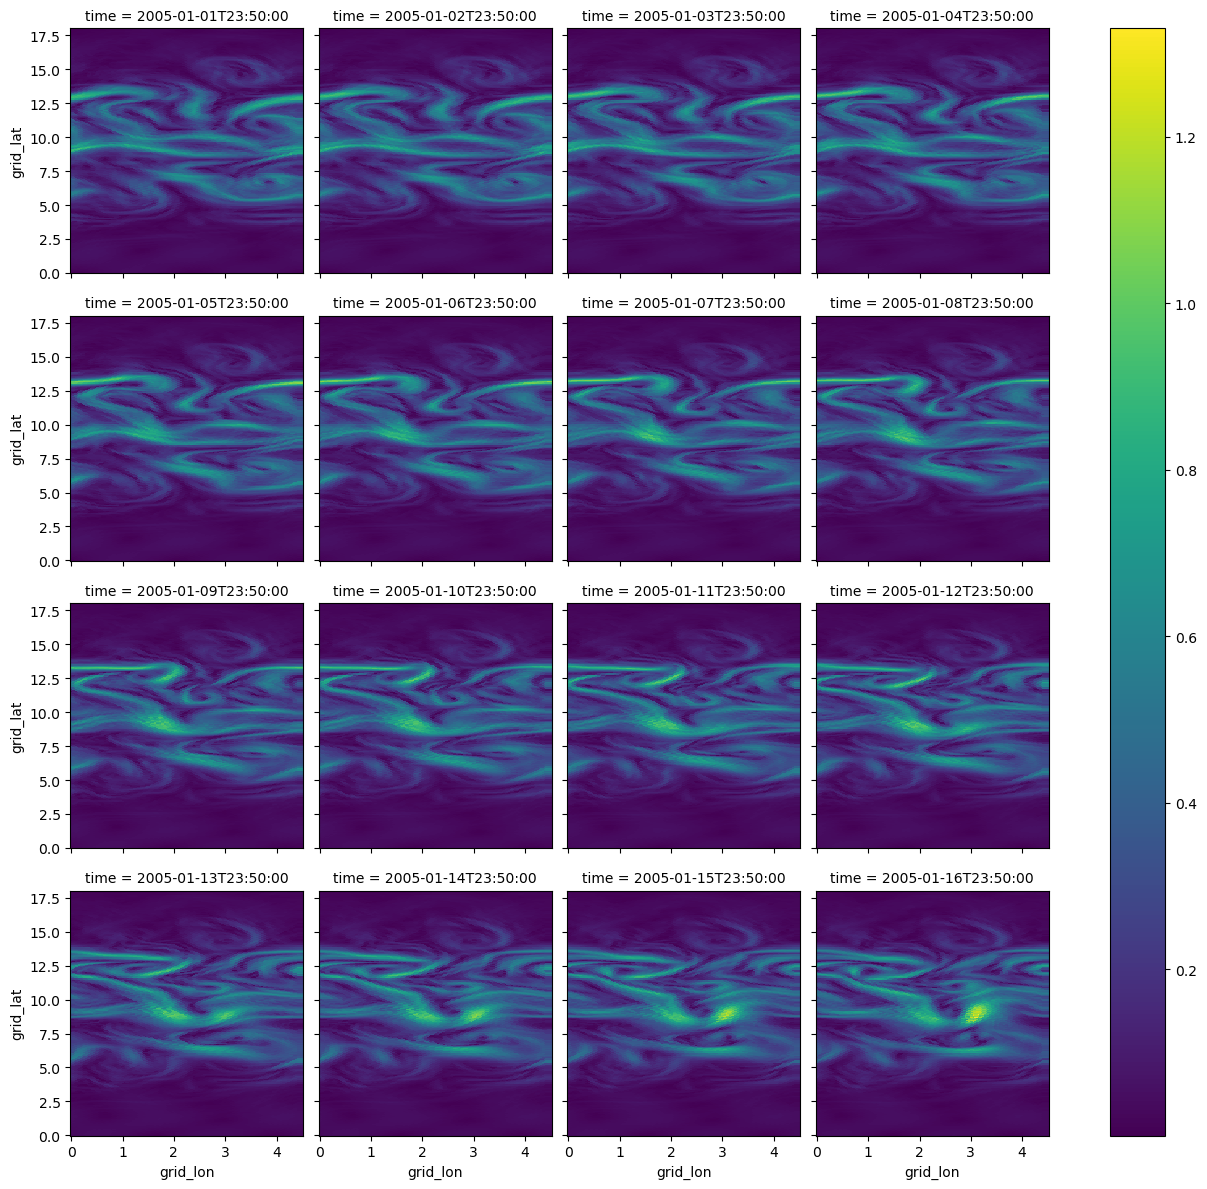

In [14]:
U_grid = ds_u.u.isel(elem=grid_elems - 1).compute() 
V_grid = ds_v.v.isel(elem=grid_elems - 1).compute()

SPD_grid = (U_grid**2 + V_grid**2) **0.5
SPD_grid.isel(time=slice(None,16)).plot(x='grid_lon', 
                                        y='grid_lat', col='time',col_wrap=4)

In [17]:
#create a dataset for the UV
ds_uv_grid= xr.Dataset({
    'U':U_grid,
    "V":V_grid,
})
#ds_uv_grid

## Parcels

In [18]:
from parcels import ParticleSet
from parcels import JITParticle
from parcels import AdvectionRK4
from datetime import timedelta
import numpy as np
from parcels import FieldSet

In [19]:
fieldset = FieldSet.from_xarray_dataset(
    ds_uv_grid.transpose('time','grid_lat','grid_lon'),
    variables={'U':"U", "V":"V"},
    dimensions={'lon':'grid_lon',
                'lat':'grid_lat',
                'time':'time'},
    time_periodic=False,
    allow_time_extrapolation=True,
)


### Adding the Halo

In [20]:
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

In [21]:
def periodicBC(particle,fielset,time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

In [22]:
pset = ParticleSet.from_list(
    pclass = JITParticle,
    fieldset = fieldset,
    lon=lon_start,
    lat=lat_start,
)

In [23]:
output_file = pset.ParticleFile(name=out_path+out_fn, 
                                outputdt=timedelta(hours=hours))

In [24]:
## Execute particles
pset.execute(
    [AdvectionRK4,periodicBC],
    runtime=timedelta(days=days),
    dt=timedelta(minutes=minutes),
    output_file= output_file
)

INFO: Output files are stored in /gxfs_work/geomar/smomw662/FESOMparcels_first/data/UV_tracking_fesom.zarr.
100%|████████████████| 25920000.0/25920000.0 [06:41<00:00, 64575.97it/s]


### Make a beutiful plot

In [3]:
from itertools import zip_longest
from functools import reduce
from operator import add
from pathlib import Path
import tqdm

In [4]:
ds_traj = xr.open_zarr("../data/"+out_fn+".zarr")
ds_traj = ds_traj.compute()
ds_traj

<xarray.Dataset> Size: 36MB
Dimensions:     (trajectory: 1000, obs: 1800)
Coordinates:
  * obs         (obs) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    lat         (trajectory, obs) float32 7MB 8.168 8.153 8.133 ... 10.81 10.81
    lon         (trajectory, obs) float32 7MB 2.461 2.434 2.407 ... 1.704 1.722
    time        (trajectory, obs) datetime64[ns] 14MB 2005-01-01T23:50:00 ......
    z           (trajectory, obs) float32 7MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4periodicBC
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [21]:
# ds_traj.drop_encoding().to_netcdf('trajs.nc')

In [5]:
skip_this_step = abs(ds_traj.lon.diff('obs')) > 4.0
skip_this_step

<xarray.DataArray 'lon' (trajectory: 1000, obs: 1799)> Size: 2MB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * obs         (obs) int32 7kB 1 2 3 4 5 6 7 ... 1794 1795 1796 1797 1798 1799
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999

In [12]:
ds_traj_nowrap = ds_traj.where(~skip_this_step)

<Axes: xlabel='lon'>

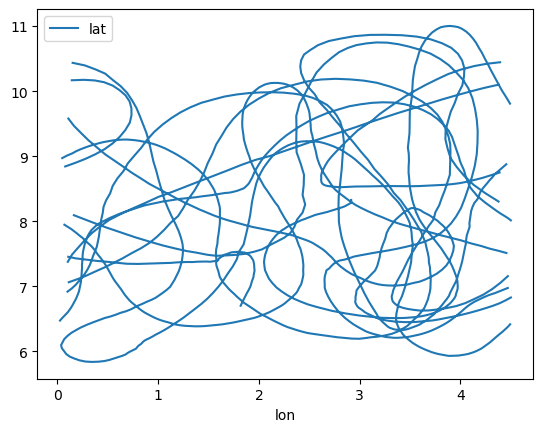

In [13]:
ds_traj_nowrap.isel(trajectory=123).to_pandas().plot.line(
    x='lon', y='lat',
)

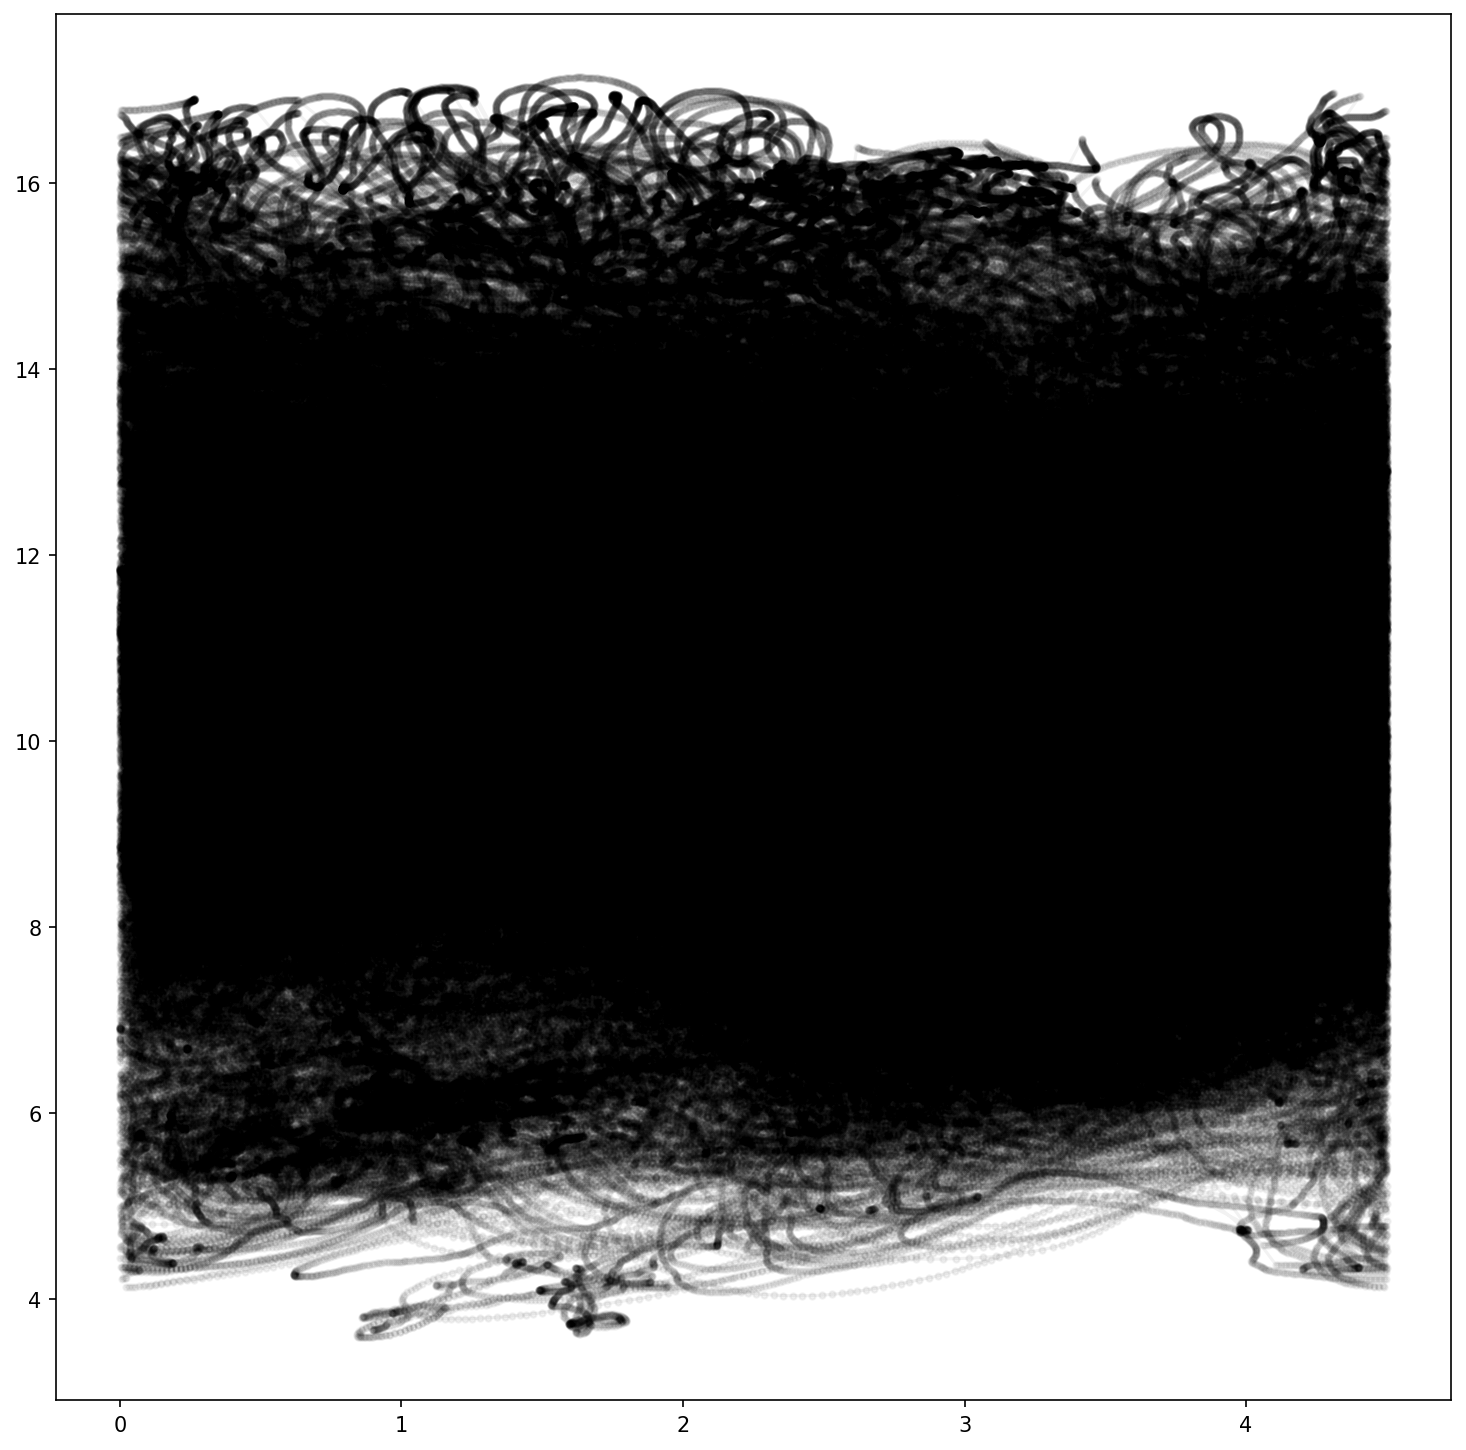

In [34]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# fig.set_dpi(150)
# ax.plot( 
#     ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).lon.compute().data.flatten(),
#     ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).lat.compute().data.flatten(),
#     '.-', color="k", alpha=0.05
# )

In [5]:
#     ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).lon.compute().data.flatten(),
#     ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).lat.compute().data.flatten(),
lati = ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).lat.compute()
loni = ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).lon.compute()
timeis =ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).time.compute()
zz = ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).z.compute()
obsi=ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).obs.compute()
traji=ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).trajectory.compute()

zz

<xarray.DataArray 'z' (trajectory: 1000, obs: 1799)> Size: 7MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * obs         (obs) int32 7kB 1 2 3 4 5 6 7 ... 1794 1795 1796 1797 1798 1799
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Attributes:
    long_name:      
    positive:       down
    standard_name:  depth
    units:          m

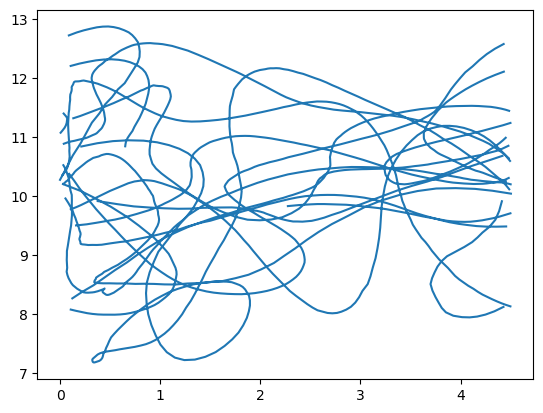

In [6]:
plt.plot(loni[4].data.flatten(),lati[4].data.flatten())

In [101]:
# indx = np.where(loni[3].data.flatten()==null)
# indx
# np.set_printoptions(threshold=1000)
# print(loni[3])

nan_indices_slice = np.where(np.isnan(loni[3].data))
nan_indices_slice

(array([ 179,  296,  468,  569,  675,  699,  700,  701,  704,  948,  966,
        1206, 1342, 1430, 1702, 1745]),)

In [7]:
ds_part = xr.Dataset(
    data_vars ={
        'lat': (('trajectory','obs'),lati.data),
        'lon': (('trajectory','obs'),loni.data),
        'time':(('trajectory','obs'),timeis.data),
        'z' : (('trajectory','obs'),zz.data),
    },
    coords = {
        'obs': obsi,
        'trajectory': ds_traj.trajectory,
    }
)
ds_part

<xarray.Dataset> Size: 36MB
Dimensions:     (trajectory: 1000, obs: 1799)
Coordinates:
  * obs         (obs) int32 7kB 1 2 3 4 5 6 7 ... 1794 1795 1796 1797 1798 1799
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    lat         (trajectory, obs) float32 7MB 8.153 8.133 8.113 ... 10.81 10.81
    lon         (trajectory, obs) float32 7MB 2.434 2.407 2.372 ... 1.704 1.722
    time        (trajectory, obs) datetime64[ns] 14MB 2005-01-02T03:50:00 ......
    z           (trajectory, obs) float32 7MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

### Subsection

In [16]:
# loni = np.reshape(ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).lon.compute().data.flatten(),
#                   [1000 ,1799])
# lati = np.reshape(ds_traj.where(abs(ds_traj.lon.diff('obs')) < 4).lat.compute().data.flatten(),
#                   [1000 ,1799])

# loni2 = np.pad(loni, ((0, 0), (1, 0)), constant_values=np.nan)
# lati2 = np.pad(lati, ((0, 0), (1, 0)), constant_values=np.nan)

# # print(loni2.shape)
# # print(ds_part.lon.shape)


In [17]:
# loni2

array([[       nan, 2.4336767 , 2.4073448 , ..., 3.677522  , 3.707616  ,
        3.7378364 ],
       [       nan, 2.5545554 , 2.5160792 , ..., 0.85873324, 0.8847613 ,
        0.910408  ],
       [       nan, 2.342607  , 2.3527741 , ..., 3.3454492 , 3.362223  ,
        3.3787985 ],
       ...,
       [       nan, 2.6212735 , 2.6716406 , ..., 3.1219382 , 3.0992675 ,
        3.0753646 ],
       [       nan, 2.3889441 , 2.3829405 , ..., 1.2424706 , 1.246981  ,
        1.2510804 ],
       [       nan, 2.1452117 , 2.1292162 , ..., 1.6868422 , 1.7043236 ,
        1.7219496 ]], dtype=float32)

In [18]:
# ds_traj['lat'] = (('trajectory','obs'),lati2)
# ds_traj['lon'] = (('trajectory','obs'),loni2)
# #ds_traj = ds_part
# ds_traj

<xarray.Dataset> Size: 36MB
Dimensions:     (trajectory: 1000, obs: 1800)
Coordinates:
  * obs         (obs) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    lat         (trajectory, obs) float32 7MB nan 8.153 8.133 ... 10.81 10.81
    lon         (trajectory, obs) float32 7MB nan 2.434 2.407 ... 1.704 1.722
    time        (trajectory, obs) datetime64[ns] 14MB 2005-01-01T23:50:00 ......
    z           (trajectory, obs) float32 7MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4periodicBC
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [10]:
def line_between(start, end):
    """Find intermediate points on a line from (x0, y0) to (x1, y1).
    
    Parameters
    ----------
    start: tuple
        Contains x0 and y0.
    end: tuple
        Contains x1 and y1.
    
    Returns
    -------
    list
        List of all intermediate points (x, y).
    
    """
    x0, y0 = start
    x1, y1 = end
    N = max(abs(x1 - x0) + 1, abs(y1 - y0) + 1)
    dx = (x1 - x0) / (N - 1)
    dy = (y1 - y0) / (N - 1)
    xx = (round(x0 + n * dx) for n in range(N))
    yy = (round(y0 + n * dy) for n in range(N))
    return list(zip(xx, yy))

In [11]:
def line_between_sequence(points):
    """Fill in lines on all segments of points.
    
    Parameters
    ----------
    points: list
        List of points (x, y).
        
    Returns
    -------
    list
        List of points (x, y) with all segments filled in.

    """
    segments = [
        line_between(start, end)[:-1]
        for start, end in zip(points[:-1], points[1:])
    ] + [points[-1:], ]
    return reduce(add, segments)

In [8]:
lon_bds = round(ds_part.lon.min().data[()], 1) - 0.2, round(ds_part.lon.max().data[()], 1) + 0.2
lat_bds = round(ds_part.lat.min().data[()], 1) - 0.2, round(ds_part.lat.max().data[()], 1) + 0.2
lon_bds, lat_bds

((-0.2, 4.7), (3.4, 17.3))

In [17]:
# ds_part = ds_traj_nowrap

In [21]:
N = 1_000

dens = np.zeros((N, N), dtype=int)

# for t in tqdm.tqdm(range(ds_traj.sizes["traj"])):
for t in tqdm.tqdm(range(0, ds_part.sizes["trajectory"], 10)):
    lon = ds_part.isel(trajectory=t).lon
    lat = ds_part.isel(trajectory=t).lat
    lon = lon.where(~lat.isnull(), drop=False) ## drop the NaNs
    lat = lat.where(~lat.isnull(), drop=False)## drop the NaNs

    point_list = list(zip(
        np.digitize(lon.data, np.linspace(*lon_bds, N)).astype(int) - 1,
        np.digitize(lat.data, np.linspace(*lat_bds, N)).astype(int) - 1,
    ))
    point_list = [i for i, j in zip_longest(point_list, point_list[1:]) if i != j]

    pos, count = np.unique(np.array(line_between_sequence(point_list)), axis=0, return_counts=True)

    dens[*pos.T[::-1]] += count

100%|██████████████████████████████████████| 100/100 [00:19<00:00,  5.04it/s]


In [22]:
_dens = xr.DataArray(
    dens ** 0.4,
    name="traj_dens",
    dims=("lon", "lat"),
    coords={"lon": np.linspace(*lon_bds, N), "lat": np.linspace(*lat_bds, N)},
)

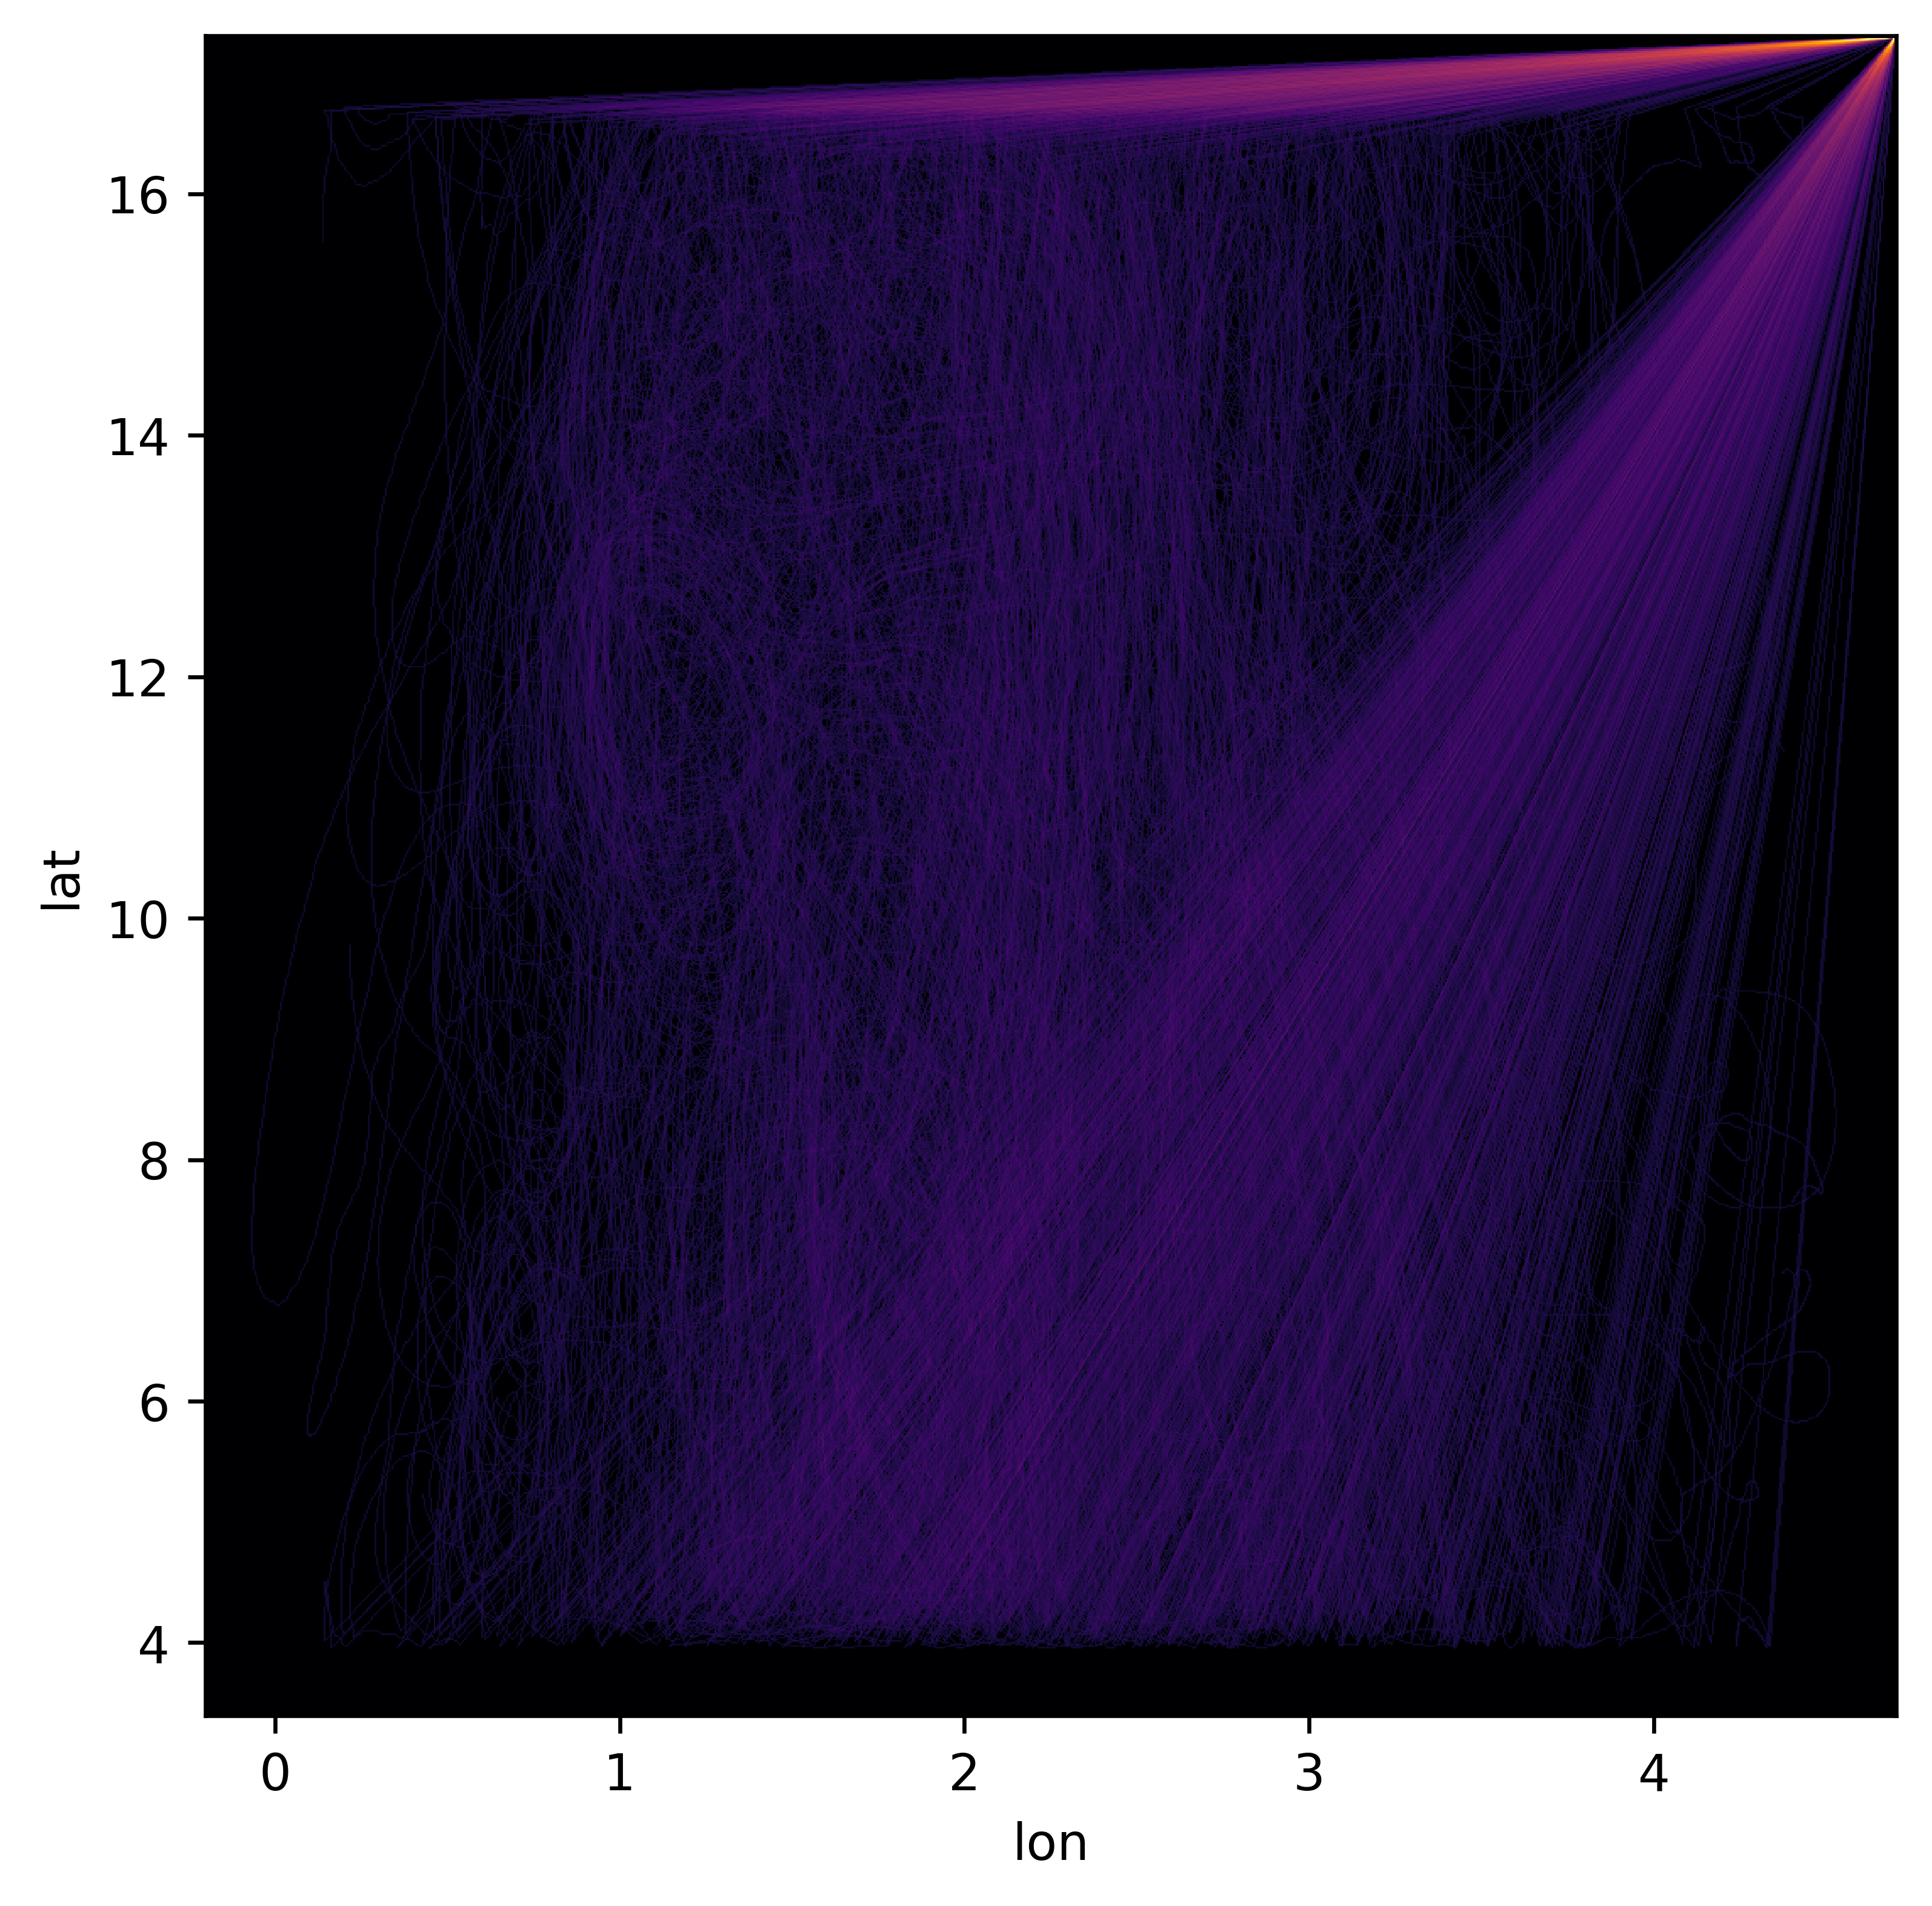

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.set_dpi(600)
_dens.plot.imshow(x='lon',cmap="inferno", ax=ax, vmax=_dens.max() * 0.75, add_colorbar=False)
# ax.axis("square")

In [18]:
_dens

<xarray.DataArray 'traj_dens' (lon: 1000, lat: 1000)> Size: 8MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 8kB -0.2 -0.1951 -0.1902 -0.1853 ... 4.69 4.695 4.7
  * lat      (lat) float64 8kB 3.4 3.414 3.428 3.442 ... 17.26 17.27 17.29 17.3

In [19]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# fig.set_dpi(150)
# ax.plot( 
#     ds_part.where(abs(ds_part.lon.diff('obs')) < 4).lon.compute().data.flatten(),
#     ds_part.where(abs(ds_part.lon.diff('obs')) < 4).lat.compute().data.flatten(),
#     '.-', color="k", alpha=0.05
# )